In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from env import user, password, host
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import os
import csv
import wrangle_zillow
import prepare

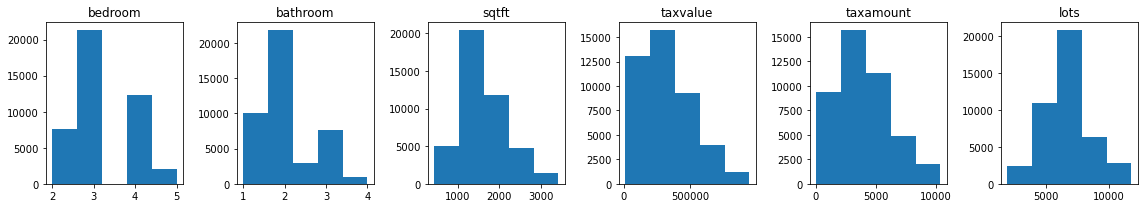

In [2]:
zillow_train,zillow_validate,zillow_test=wrangle_zillow.wrangle_zillow(1.5)

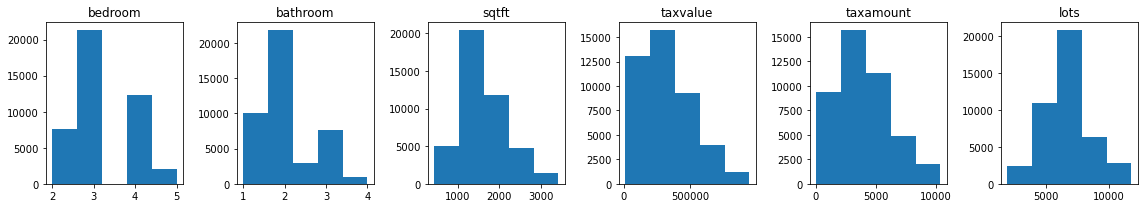

In [3]:
scaler, zillow_train_scaled, zillow_validate_scaled, zillow_test_scaled=prepare.scale(MinMaxScaler(),zillow_train,zillow_validate, zillow_test)

In [4]:
zillow_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24257 entries, 9653 to 47564
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedroom          24257 non-null  float64
 1   bathroom         24257 non-null  float64
 2   sqtft            24257 non-null  float64
 3   taxvalue         24257 non-null  float64
 4   yearbuilt        24249 non-null  object 
 5   taxamount        24257 non-null  float64
 6   fips             24257 non-null  object 
 7   lots             24257 non-null  float64
 8   zipcode          24247 non-null  object 
 9   assessmentyear   24257 non-null  object 
 10  transactiondate  24257 non-null  object 
 11  taxrate          24257 non-null  object 
dtypes: float64(6), object(6)
memory usage: 2.4+ MB


In [5]:
zillow_train.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroom,24257.0,3.198829,0.778007,2.00,3.00,3.00,4.00,5.00
bathroom,24257.0,2.022055,0.697943,1.00,2.00,2.00,2.50,4.00
sqtft,24257.0,1615.423754,541.864106,440.00,1217.00,1517.00,1928.00,3424.00
taxvalue,24257.0,320354.428825,195587.427420,9762.00,168395.00,290868.00,442170.00,947794.00
taxamount,24257.0,3975.308821,2198.399383,49.18,2310.44,3675.27,5362.48,10396.68
lots,24257.0,6647.333223,1796.088127,1890.00,5507.00,6476.00,7577.00,11823.00


In [62]:
zillow_train.taxrate.value_counts()

0.01    20355
0.02     3629
0.03      188
0.00       34
0.04       28
0.05        7
0.06        6
0.08        4
0.09        2
0.16        2
0.07        1
0.13        1
Name: taxrate, dtype: int64

# Takeaways
The training data set has 23257 rows, the max bedrooms is 5 while the max bathroom is 4. 

In [10]:
# We are going to convert fips into county
r=[]
for row in zillow_train['fips']:
    if row == 6037.0: r.append('Los Angeles, CA')
    elif row == 6059.0: r.append('Orange, CA')
    elif row == 6111 : r.append('Ventura, CA')
zillow_train['county']=r

In [11]:
zillow_train.county.value_counts()

Los Angeles, CA    16250
Orange, CA          5959
Ventura, CA         2048
Name: county, dtype: int64

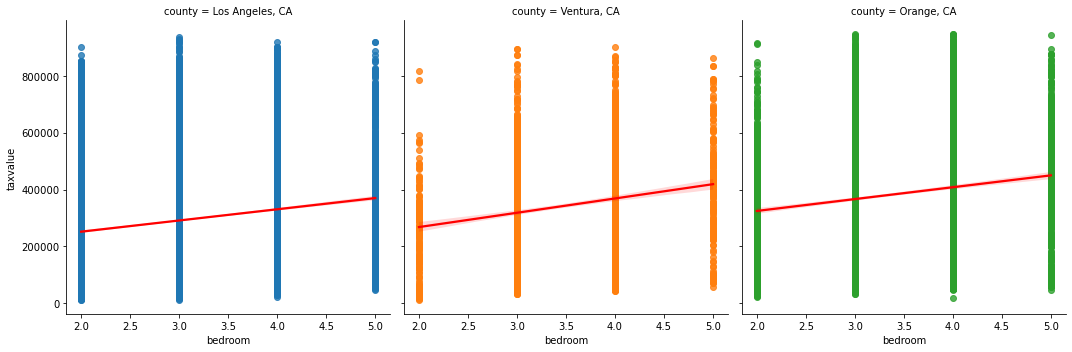

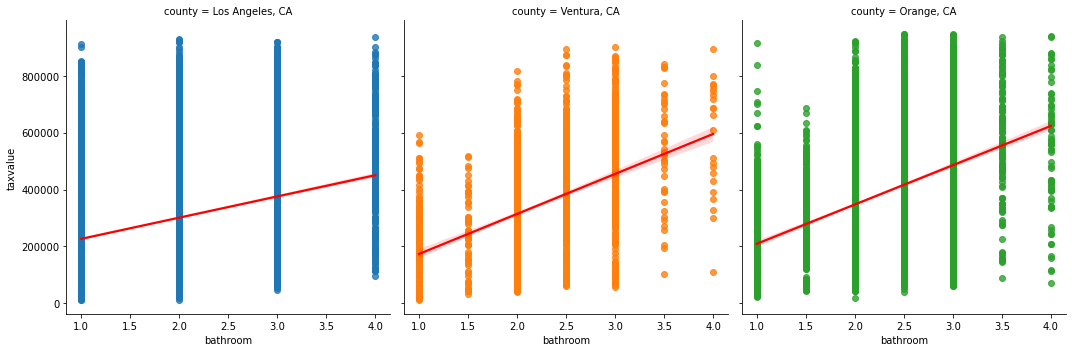

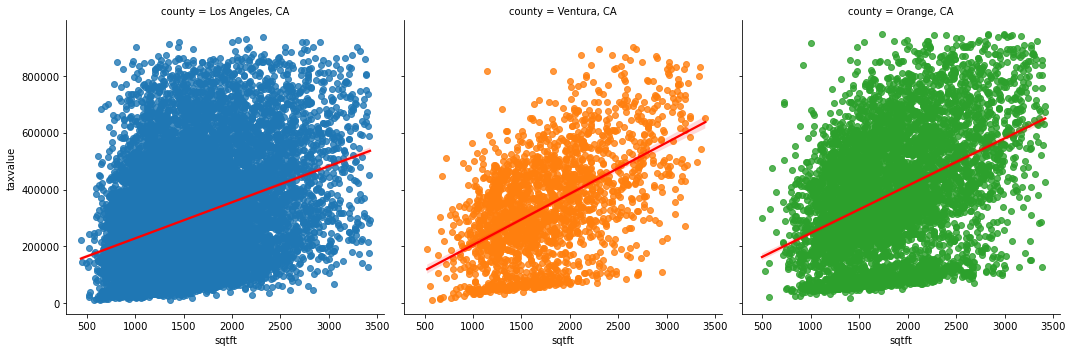

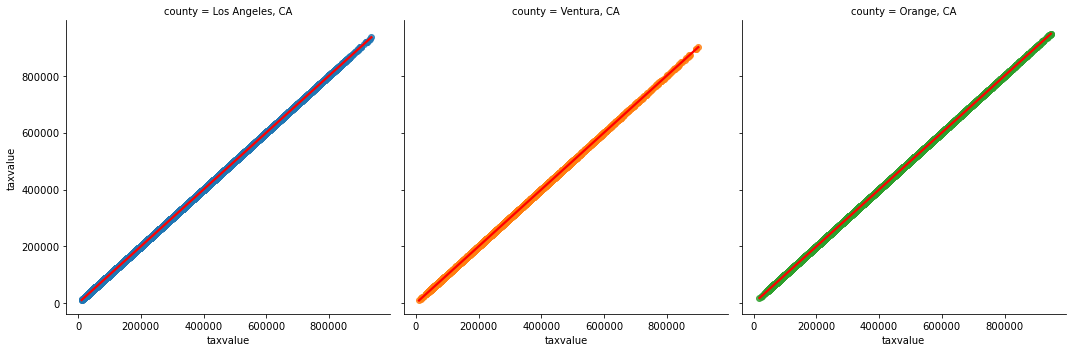

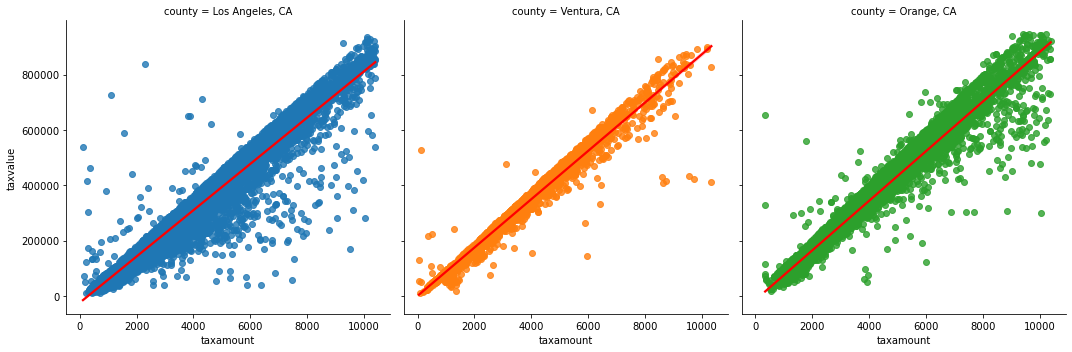

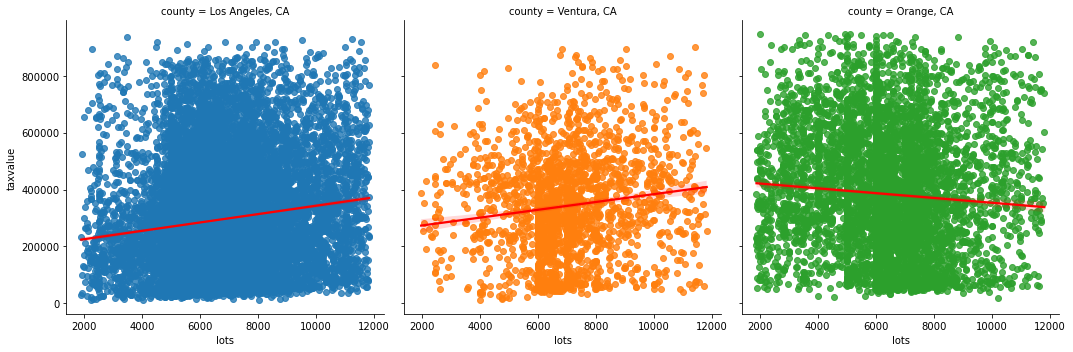

In [21]:
def plot_variable_pairs():
    columns = zillow_train.select_dtypes('float')
    for col in columns:
        sns.lmplot(x= col, y="taxvalue", data=zillow_train, col = 'county', hue = 'county', line_kws={'color': 'red'})
plot_variable_pairs()

# Key takeaway
It seems like the county has sqtft has relationship with tax value

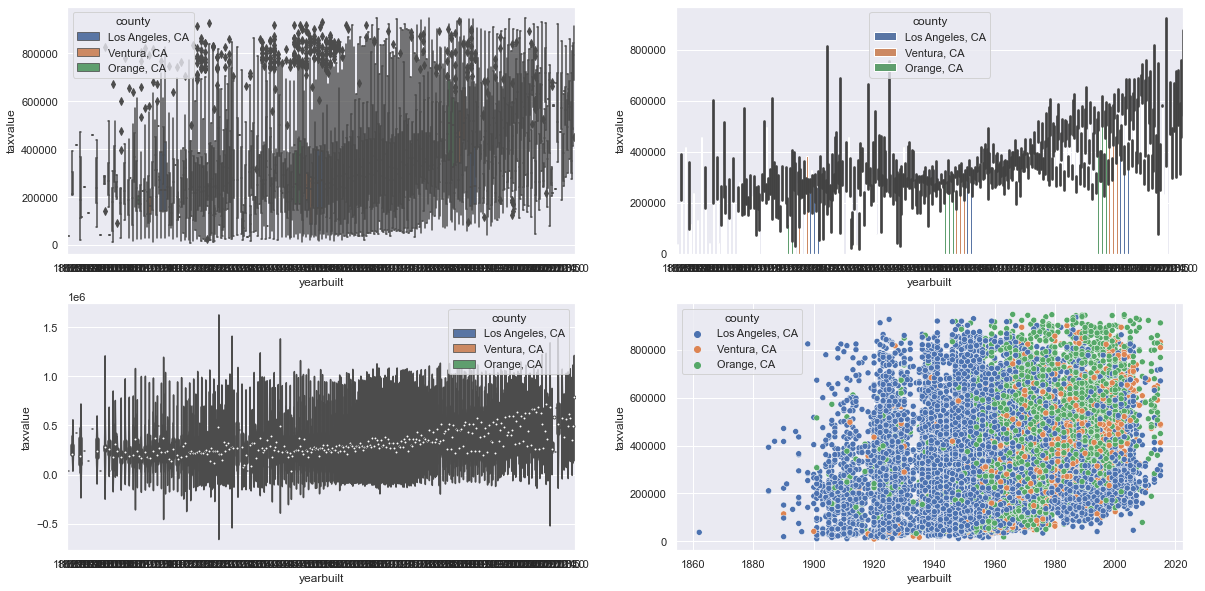

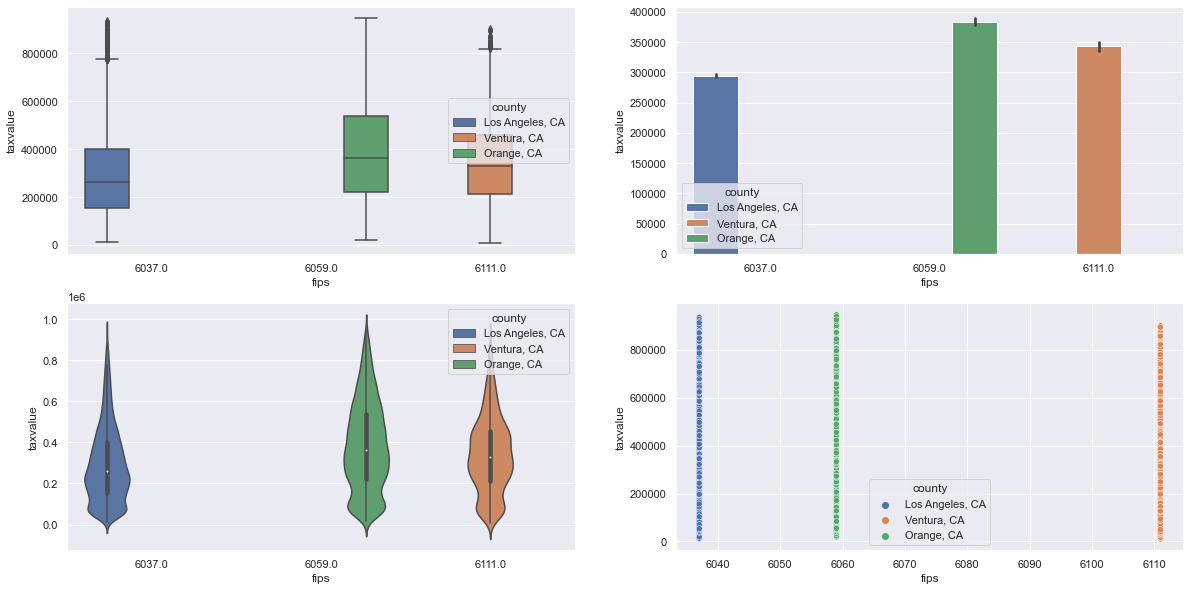

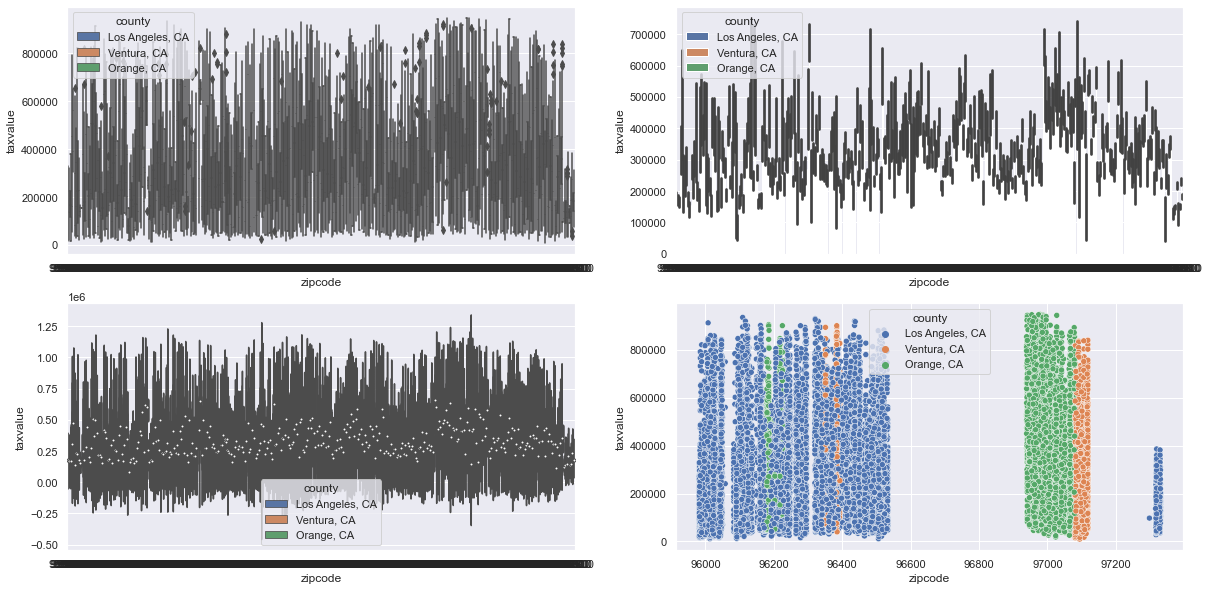

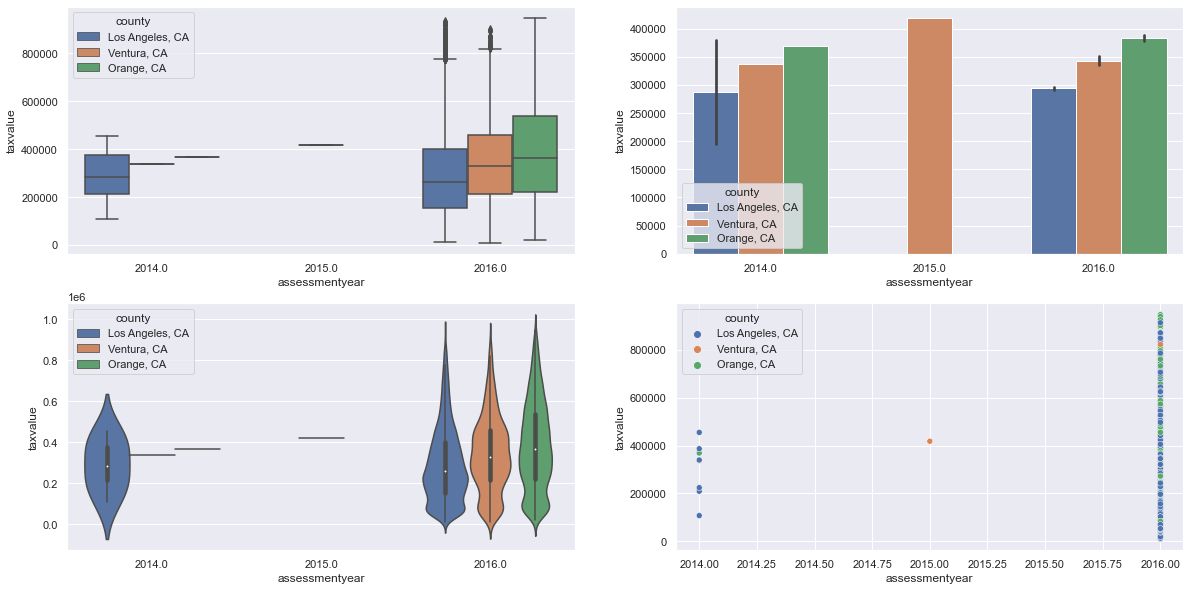

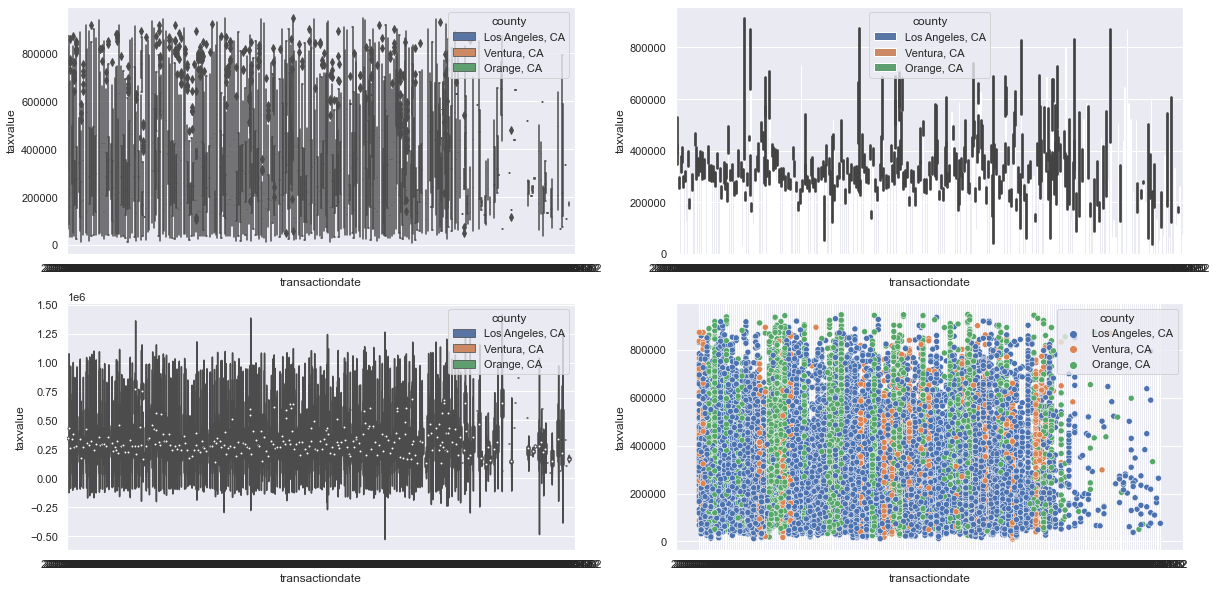

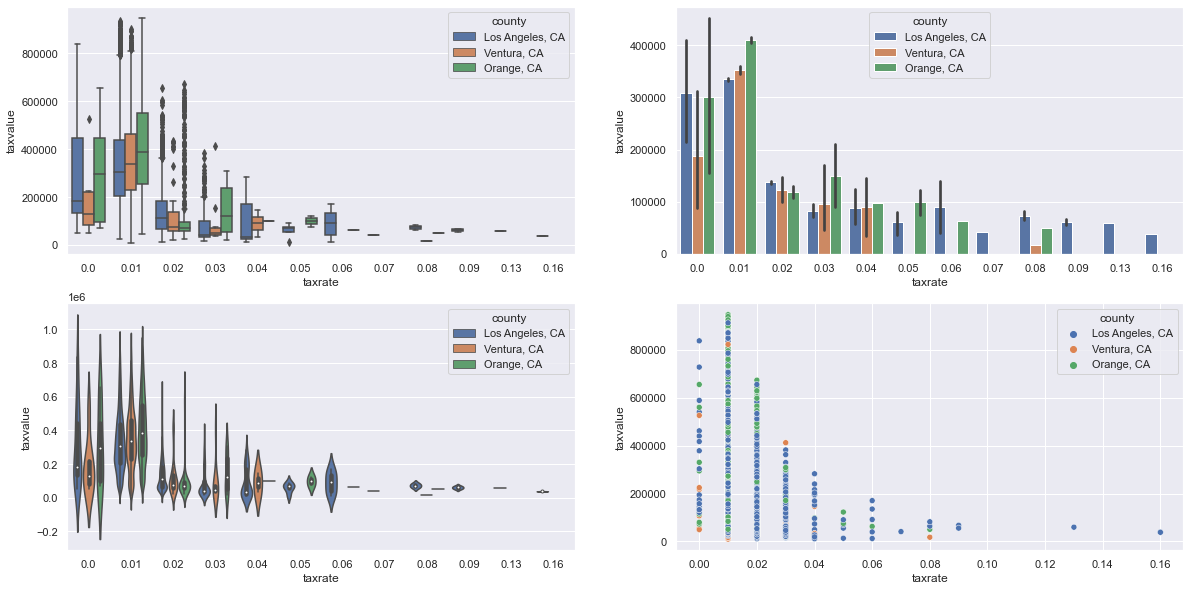

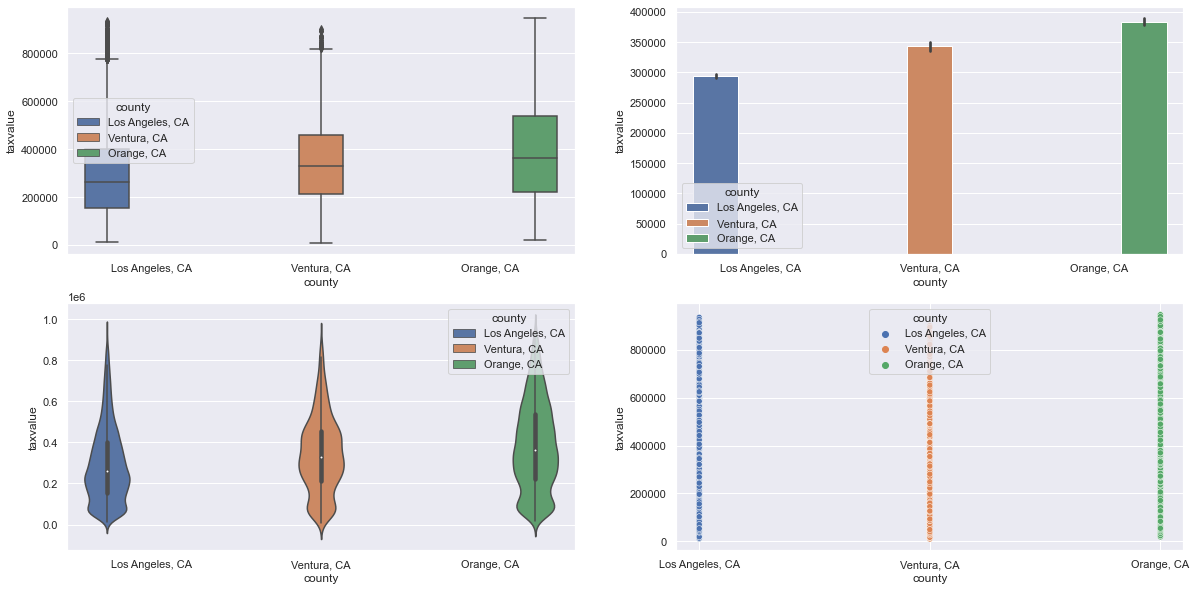

In [35]:
def plot_categorical_and_continuous_vars():
    columns = zillow_train.select_dtypes('object')
    for col in columns:
        sns.set(rc={'figure.figsize':(20,10)})
        fig, axes = plt.subplots(2,2)
        sns.boxplot(x= col, y="taxvalue", data=zillow_train, hue = 'county', ax = axes[0,0])
        sns.barplot(x= col, y="taxvalue", data=zillow_train, hue = 'county', ax = axes[0,1])
        sns.violinplot(x= col, y="taxvalue", data=zillow_train, hue = 'county', ax = axes[1,0])
        sns.scatterplot(x= col, y="taxvalue", data=zillow_train, hue = 'county', ax = axes[1,1])
plot_categorical_and_continuous_vars()

# Key Takeaway
Majority of the ventura and orange county houses are built after 1960s
orange county has higest taxvalue in compare to other two counties
majority of tax rates are below .05 percent

# Initial Hypothesis

In [36]:
# Whether the county has impact on the taxrate

In [64]:
# a=0.05
# H0=county has no impact on the taxrate
# Ha=county has impact on the taxrate

In [66]:
import scipy.stats as stats
observed = pd.crosstab(zillow_train.county,zillow_train.taxrate)
observed
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p}')

Observed

[[   20 12980  3041   166    25     5     5     1     2     2     1     2]
 [    7  5415   520    12     1     2     1     0     1     0     0     0]
 [    7  1960    68    10     2     0     0     0     1     0     0     0]]
---
Expected

[[2.27769304e+01 1.36360123e+04 2.43110236e+03 1.25943027e+02
  1.87574721e+01 4.68936802e+00 4.01945830e+00 6.69909717e-01
  2.67963887e+00 1.33981943e+00 6.69909717e-01 1.33981943e+00]
 [8.35247557e+00 5.00043060e+03 8.91503937e+02 4.61842767e+01
  6.87850930e+00 1.71962732e+00 1.47396628e+00 2.45661046e-01
  9.82644185e-01 4.91322093e-01 2.45661046e-01 4.91322093e-01]
 [2.87059406e+00 1.71855712e+03 3.06393701e+02 1.58726965e+01
  2.36401863e+00 5.91004658e-01 5.06575422e-01 8.44292369e-02
  3.37716948e-01 1.68858474e-01 8.44292369e-02 1.68858474e-01]]
---

chi^2 = 653.0091
p     = 6.215392006662306e-124


In [68]:
if p > 0.05:
    print("We fail to reject H0")
else:
    print("We reject H0")

We reject H0


# key takeaway
The chi2 test revealed that the county has impact on the tax rate